In [1]:
#load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')

In [2]:
#load data

training_values = pd.read_csv('I:/Python Scripts/DataDriven/Pump it up/Training_values.csv')
training_labels = pd.read_csv('I:/Python Scripts/DataDriven/Pump it up/Training_labels.csv')
training = pd.merge(training_values, training_labels, how = 'inner', on ='id')

train = training.set_index('id')

test = pd.read_csv('I:/Python Scripts/DataDriven/Pump it up/Test.csv')

In [3]:
#eerste inzichten (in train)

train.shape

train.head()

print(train.info())

print(train.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
recorded_by              59400 non-null obj

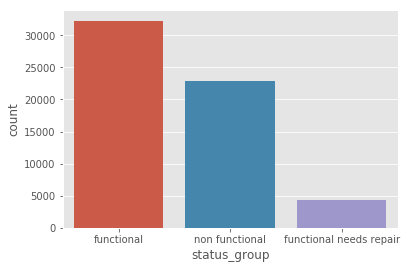

In [4]:
#target

sns.countplot( x = "status_group", data = train)


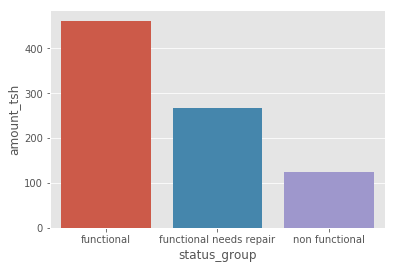

In [5]:
#amount tsh (amount of water available)
grouped = train.groupby('status_group').mean().reset_index()

sns.barplot(x = "status_group", y = "amount_tsh", data = grouped)

#gemiddeld meer water in funcationeele waterpompen

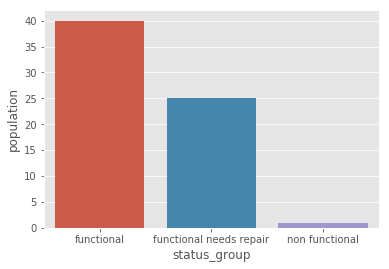

In [6]:
#population
grouped = train.groupby('status_group').median().reset_index()

sns.barplot(x = 'status_group', y = 'population', data = grouped)

#erg lage populatie bij kapotte waterpompen (logisch?)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

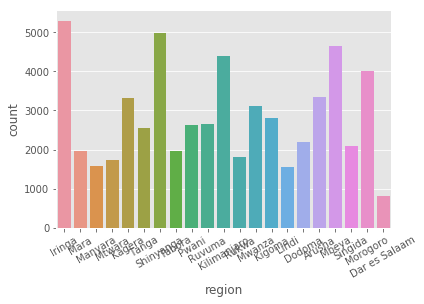

In [7]:
#funder
_= sns.countplot( x = "region", data = train)
plt.xticks(rotation = 30)

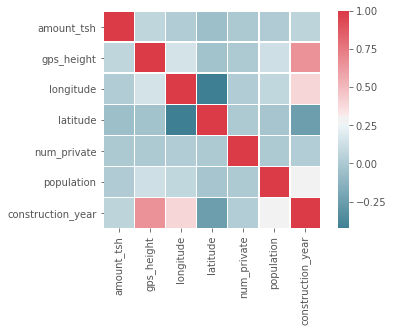

In [8]:
#corrmatrix
filtered = train.loc[:,train.columns.str.contains('code') == False]
corr = filtered.corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap = cmap, square = True, linewidth = .3)

In [9]:
#kijken naar NA
train.isnull().sum()


amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [10]:
#scheme
print(train.groupby(['scheme_management', 'scheme_name']).size())

train['scheme_management'].fillna('other', inplace = True)

scheme_management  scheme_name                 
Company            BFFS                              1
                   Bagamoyo Wate                    60
                   Bagamoyo wate                   210
                   Borehole                          1
                   Borehole drilling project         1
                   Bulamba piped scheme              2
                   Burieni water supply              1
                   Doe water supply                  3
                   EKTM 2 water  supply              1
                   EKTM 2 water suply               25
                   EKTM 2 water supply               9
                   EKTM 3 water supply              51
                   Fufulamsuri water supply          1
                   GRUMETI                           6
                   HESAWA                            1
                   Hakwe water supply               10
                   Holili water supply              23
                 

In [11]:
#waterpoint
print(train.groupby(['waterpoint_type', 'waterpoint_type_group']).size())


waterpoint_type              waterpoint_type_group
cattle trough                cattle trough              116
communal standpipe           communal standpipe       28522
communal standpipe multiple  communal standpipe        6103
dam                          dam                          7
hand pump                    hand pump                17488
improved spring              improved spring            784
other                        other                     6380
dtype: int64


In [12]:
print(train.groupby(['extraction_type', 'extraction_type_group', 'extraction_type_class']).size())


extraction_type            extraction_type_group  extraction_type_class
afridev                    afridev                handpump                  1770
cemo                       other motorpump        motorpump                   90
climax                     other motorpump        motorpump                   32
gravity                    gravity                gravity                  26780
india mark ii              india mark ii          handpump                  2400
india mark iii             india mark iii         handpump                    98
ksb                        submersible            submersible               1415
mono                       mono                   motorpump                 2865
nira/tanira                nira/tanira            handpump                  8154
other                      other                  other                     6430
other - mkulima/shinyanga  other handpump         handpump                     2
other - play pump          other hand

In [13]:
#management
print(train.groupby(['management', 'management_group']).size())


management        management_group
company           commercial            685
other             other                 844
other - school    other                  99
parastatal        parastatal           1768
private operator  commercial           1971
trust             commercial             78
unknown           unknown               561
vwc               user-group          40507
water authority   commercial            904
water board       user-group           2933
wua               user-group           2535
wug               user-group           6515
dtype: int64


In [14]:
print(train.groupby(['public_meeting']).size())

public_meeting
False     5055
True     51011
dtype: int64


In [15]:

#van NA naar 0
train['funder'].fillna('other', inplace = True)
train['installer'].fillna('other', inplace = True)


#drop factors
train.drop(['subvillage', 'permit', 'public_meeting', 'wpt_name', 'num_private', 'region', 'scheme_name', 
            'extraction_type', 'payment', 'source_type', 'ward', 'date_recorded' ], axis = 1, inplace = True)


In [16]:
train.isnull().sum()

amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region_code              0
district_code            0
lga                      0
population               0
recorded_by              0
scheme_management        0
construction_year        0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
status_group             0
dtype: int64

In [17]:
#test data aanpassen 
test.set_index('id', inplace = True)
#van NA naar 0
test['funder'].fillna('other', inplace = True)
test['installer'].fillna('other', inplace = True)
test['scheme_management'].fillna('other', inplace = True)

#drop factors
test.drop(['subvillage', 'permit', 'public_meeting', 'wpt_name', 'num_private', 'region', 'scheme_name', 
            'extraction_type', 'payment', 'source_type', 'ward' , 'date_recorded'], axis = 1, inplace = True)

In [37]:

train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)

dataset_preprocessed = pd.get_dummies(dataset.loc[:,dataset.columns != 'status_group'], drop_first = True)
train_preprocessed = dataset_preprocessed[:train_objs_num]
test_preprocessed = dataset_preprocessed[train_objs_num:]



KeyError: MemoryError()

In [21]:
train_cols = train_preprocessed.columns
test_cols = test_preprocessed.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
print(common_cols)
print(test_preprocessed.filter(like = 'status').columns)

Index(['amount_tsh', 'construction_year', 'district_code', 'gps_height',
       'latitude', 'longitude', 'population', 'region_code',
       'basin_Lake Nyasa', 'basin_Lake Rukwa',
       ...
       'waterpoint_type_communal standpipe multiple', 'waterpoint_type_dam',
       'waterpoint_type_hand pump', 'waterpoint_type_improved spring',
       'waterpoint_type_other', 'waterpoint_type_group_communal standpipe',
       'waterpoint_type_group_dam', 'waterpoint_type_group_hand pump',
       'waterpoint_type_group_improved spring', 'waterpoint_type_group_other'],
      dtype='object', length=4783)
Index([], dtype='object')


In [27]:
training_labels.set_index('id', inplace = True)

train = pd.merge(train_preprocessed, training_labels, how = 'inner', left_index =True, right_index = True)


train.head()


,amount_tsh,construction_year,district_code,gps_height,latitude,longitude,population,region_code,basin_Lake Nyasa,basin_Lake Rukwa,...,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,1999,5,1390,-9.856322,34.938093,109,11,1,0,...,0,0,0,0,1,0,0,0,0,functional
8776,0.0,2010,2,1399,-2.147466,34.698766,280,20,0,0,...,0,0,0,0,1,0,0,0,0,functional
34310,25.0,2009,4,686,-3.821329,37.460664,250,21,0,0,...,0,0,0,0,1,0,0,0,0,functional
67743,0.0,1986,63,263,-11.155298,38.486161,58,90,0,0,...,0,0,0,0,1,0,0,0,0,non functional
19728,0.0,0,1,0,-1.825359,31.130847,0,18,0,0,...,0,0,0,0,1,0,0,0,0,functional


In [28]:
y = train['status_group'] .values
X = train.drop('status_group', axis = 1).values

#create hyperparamater grid
c_space = np.logspace(-10, 8, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

#instantiate log reg classifier
logreg = LogisticRegression()


#create train/test split on train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 2018)


#GridSearchCV
logreg_cv = GridSearchCV(logreg,  param_grid = param_grid , cv = 10)


# Fit it to the training data
logreg_cv.fit(X_train, y_train,)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

# Predict the labels of the test set: y_pred
y_pred_probs = logreg_cv.predict_proba(X_test)

score = log_loss(y_test, y_pred_probs)

print("Tuned Logistic Regression Log loss: {}".format(score))


Tuned Logistic Regression Parameter: {'C': 1.0, 'penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.7583333333333333
Tuned Logistic Regression Log loss: 0.5838727427613936


In [29]:
y_pred = logreg_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))



[[11538   130  1231]
 [ 1164   243   310]
 [ 2737    61  6346]]


In [23]:
# Logistic Regression heeft hogere log loss


Prediction = logreg_cv.predict(test_preprocessed)

Prediction

ValueError: X has 4783 features per sample; expecting 4784

In [48]:
test_preprocessed.head()

,amount_tsh,construction_year,district_code,gps_height,latitude,longitude,population,region_code,basin_Lake Nyasa,basin_Lake Rukwa,...,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,Prediction
id,,,,,,,,,,,,,,,,,,,,,
50785,0.0,2012,3,1996,-4.059696,35.290799,321,21,0,0,...,0,0,0,1,0,0,0,0,1,non functional
51630,0.0,2000,2,1569,-3.309214,36.656709,300,2,0,0,...,0,0,0,0,1,0,0,0,0,functional
17168,0.0,2010,2,1567,-5.004344,34.767863,500,13,0,0,...,0,0,0,1,0,0,0,0,1,functional
45559,0.0,1987,43,267,-9.418672,38.058046,250,80,0,0,...,0,0,0,1,0,0,0,0,1,non functional
49871,500.0,2000,3,1260,-10.950412,35.006123,60,10,0,0,...,0,0,0,0,1,0,0,0,0,functional


In [47]:
print(test_preprocessed.head())
#test_preprocessed.drop('Prediction', axis = 1, inplace = True)


test_preprocessed['Prediction'] = logreg_cv.predict(test_preprocessed)







       amount_tsh  construction_year  district_code  gps_height   latitude  \
id                                                                           
50785         0.0               2012              3        1996  -4.059696   
51630         0.0               2000              2        1569  -3.309214   
17168         0.0               2010              2        1567  -5.004344   
45559         0.0               1987             43         267  -9.418672   
49871       500.0               2000              3        1260 -10.950412   

       longitude  population  region_code  basin_Lake Nyasa  basin_Lake Rukwa  \
id                                                                              
50785  35.290799         321           21                 0                 0   
51630  36.656709         300            2                 0                 0   
17168  34.767863         500           13                 0                 0   
45559  38.058046         250           80       

ValueError: could not convert string to float: 'non functional'

In [51]:
Submission = test_preprocessed.loc[:,['Prediction']]

Submission.head()

,Prediction
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [52]:
Submission = Submission.rename(columns = {'Prediction':'status_group'})

Submission.to_csv('I:/Python Scripts/DataDriven/Pump it up/Submission.csv', index=True)